# Exercise 2

## Fundamentals of Machine Learning

#### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl

#### Version information:
        2020-12-07: v.1.0. First public release. 


In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn import model_selection

## 3 - Data Preparation
We filter the full digits dataset such that only the digits "1" and "7" are left. Of the remaining 361 instances, we split these up into a training and test set with proportions 3 to 2 respectively.

In [2]:
# Import the digits dataset
digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

# Filter out ones and sevens from the dataset.
mask = (target == 1) | (target == 7)
data_filtered   = data[mask,:]
target_filtered = target[mask]

# Create training and test sets.
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_filtered,target_filtered,test_size=0.4,random_state=0)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
X_train.shape[0]/X_test.shape[0]

1.4896551724137932

### 3.1 - Dimension reduction (3 pts)
We use a simple minded approach of looking at the average images of each class and finding two pixels that have the largest difference in the average pixel values. These two pixels should theoretically best characterise and differentiate each class from one another.

[60 19]


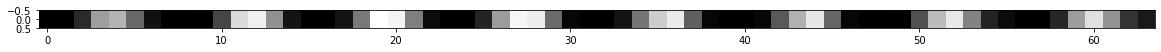

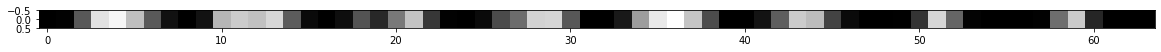

In [4]:
mask_ones     = (target == 1) 
mask_sevens   = (target == 7)
data_ones   = data[mask_ones,:]
data_sevens = data[mask_sevens,:]

data_avg_one   = np.average(data_ones, axis=0)
data_avg_seven = np.average(data_sevens, axis=0)

pixel_candidates =  np.argsort(data_avg_one-data_avg_seven)[-2:]
print(pixel_candidates)

plt.figure(figsize=(20,10))
plt.gray()
plt.imshow(data_avg_one[None,:], interpolation="nearest")
plt.show()

plt.figure(figsize=(20,10))
plt.gray()
plt.imshow(data_avg_seven[None,:], interpolation="nearest")
plt.show()

So, the pixels with the flattened indices 19 and 60 are the two pixels with the largest differences between the two class averages. These linear indices corresponds to 2D indicies (3,2) and (4,7). We plot in 2d to confirm that our choice of pixels makes sense. 

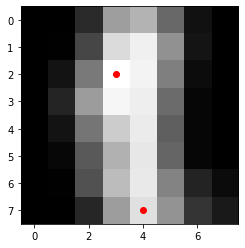

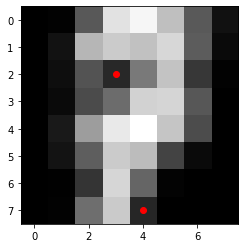

In [5]:
images_ones   = images[mask_ones,:,:]
images_sevens = images[mask_sevens,:,:]

img_avg_one   = np.average(images_ones, axis=0)
img_avg_seven = np.average(images_sevens, axis=0)

x = pixel_candidates % 8
y = pixel_candidates // 8

plt.figure()
plt.gray()
plt.imshow(img_avg_one, interpolation="nearest")
plt.scatter(x,y, color='red')
plt.show()

plt.figure()
plt.gray()
plt.imshow(img_avg_seven, interpolation="nearest")
plt.scatter(x,y, color='red')
plt.show()

Thus, we implement an function to reduce the number of dimensions from 64 to 2. This is done by only considering the pixel values in each of these two pixels for each instance. Effectivley, only these two feature dimensions are considered henceforth, all others are ignored.

In [6]:
def reduce_dim(x):
    return x[:,pixel_candidates]

### 3.2 - Scatterplot (4 pts)